# Overview of Fast Food Restaurants in the US by Calories

## Introduction

This dashboard presents a comprehensive analysis of nutritional information from various fast food restaurants. The analysis encompasses data scraping, data cleaning, enrichment using the OpenAI API, and exploratory data analysis (EDA) to provide insights into the calorie distribution of main dishes across different restaurants.


## Data Collection

The data was scraped from fastfoodnutrition.org, a website that collects nutritional data from dozens of popular fast food restaurants in the US. 

First, I used **BeautifulSoup4** to parse the HTML to extract the URLs of all individual restaurants on the main page.

```python
import os
import csv
from bs4 import BeautifulSoup
import pandas as pd
import requests

# The URL you're scraping
url = "https://fastfoodnutrition.org/fast-food-restaurants"

# Include headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Make the request to the URL
response = requests.get(url, headers=headers)

# Ensure the request was successful
if response.status_code == 200:
    # Parse the HTML content
    soup = BeautifulSoup(response.text, 'html.parser')

    # Initialize an empty list to hold the extracted links
    restaurant_links = []

    # Base URL for constructing the full URL
    base_url = 'https://fastfoodnutrition.org'

    # Find all <a> tags and extract the 'href' attributes
    for link in soup.find_all('a', href=True):
        if "/nutrition-facts" not in link['href']:  # Skip non-restaurant links
            full_url = base_url + link['href']
            restaurant_links.append(full_url)

    # Remove duplicates and create DataFrame
    df_restaurant_links = pd.DataFrame(list(set(restaurant_links)), columns=['Link'])

    # Define the relative path for the CSV file
    csv_file_path = '../../data/interim/restaurant_links.csv'

    # Ensure the directory exists
    os.makedirs(os.path.dirname(csv_file_path), exist_ok=True)

    # Save the DataFrame to a CSV file, quoting all non-numeric fields
    df_restaurant_links.to_csv(csv_file_path, index=False, quoting=csv.QUOTE_NONNUMERIC)

    print(f"Restaurant links saved to {csv_file_path}")
else:
    print(f"Failed to fetch the webpage. Status code: {response.status_code}")
```

Next, I used the URLs to scrape the nutritional information for each restaurant. 

I extracted the name of the restaurant, the name of every item that restaurant currently offers along with its calorie count. 

I then saved the data to a CSV file for further use later.

```python
import json
from bs4 import BeautifulSoup
import pandas as pd
import requests

# Read the list of restaurant links from the CSV file
restaurant_links = pd.read_csv('../../data/interim/restaurant_links.csv')

# Initialize an empty DataFrame to store the results from all restaurants
all_menu_items = pd.DataFrame()

# Define headers to mimic a browser request
headers = {
    'User-Agent': 'Mozilla/5.0 (Windows NT 10.0; Win64; x64) AppleWebKit/537.36 (KHTML, like Gecko) Chrome/91.0.4472.124 Safari/537.36'
}

# Iterate over each restaurant URL
for index, row in restaurant_links.iterrows():
    url = row['Link']
    # Validate URL format
    if not url.startswith('http'):
        url = 'https://' + url

    restaurant_name = url.split('/')[-1]  # Extracting the restaurant name from the URL

    try:
        # Fetch the page content with headers
        response = requests.get(url, headers=headers)
        if response.status_code != 200:
            print(f"Skipping {url} due to status code {response.status_code}")
            continue

        soup = BeautifulSoup(response.content, 'html.parser')

        # Find the script tag with the JSON content
        script_tag = soup.find('script', type='application/ld+json')

        # Check if the script tag is found and proceed with JSON parsing
        if script_tag:
            try:
                menu_data = json.loads(script_tag.string)
                if 'menu' not in menu_data or 'hasMenuSection' not in menu_data['menu']:
                    print(f"Skipping {url} as it does not contain menu data.")
                    continue

                menu_items = []

                # Extract menu item names and calorie information
                for section in menu_data['menu']['hasMenuSection']:
                    for item in section['hasMenuItem']:
                        item_name = item['name']
                        calories = item['nutrition']['calories'].replace(' calories', '')  # Removing 'calories' text
                        menu_items.append({'Restaurant': restaurant_name, 'Item': item_name, 'Calories': calories})

                # Convert the list to a DataFrame
                df_menu_items = pd.DataFrame(menu_items)

                # Append the results to the all_menu_items DataFrame
                all_menu_items = pd.concat([all_menu_items, df_menu_items], ignore_index=True)
            except json.decoder.JSONDecodeError as e:
                print(f"Skipping {url} due to JSON parsing error: {e}")
    except requests.exceptions.RequestException as e:
        print(f"Error fetching {url}: {e}")

# Save the consolidated data to a CSV file
all_menu_items.to_csv('../../data/processed/all_restaurants_menu_items.csv', index=False)
```
    

Before any further work, I decided to create a copy of the original dataset to avoid any potential data loss.

```python
import pandas as pd

# Path to the original CSV file
original_file_path = ('/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/'
                      'all_restaurants_menu_items.csv')

# Path to the new CSV file
new_file_path = '/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/items.csv'

# Read the original CSV file
df = pd.read_csv(original_file_path)

# Save the DataFrame to the new CSV file
df.to_csv(new_file_path, index=False)

print(f"Copied '{original_file_path}' to '{new_file_path}'")
```

## OpenAI API Integration

I used the OpenAI API to classify the menu items into categories based on their names and calorie content.

- **Model Used:** GPT-3.5-turbo-0125 and GPT-3.5-turbo 
- **Task:** Classifying menu items based on their names and calorie content, and appending the classification to the original dataset.
- **Output:** Each item was labeled with one of the predetermined categories to facilitate further analysis.

```python
import os
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv

# Load the .env file to get the API key
load_dotenv()

# Initialize the OpenAI client with your API key
openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

# Load the items CSV file
file_path = '/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/items.csv'
items_df = pd.read_csv(file_path)

# Define the batch size
batch_size = 100

# Path for the output classifications file
output_file_path = '/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/classifications.csv'

# Write the header to classifications.csv
with open(output_file_path, 'w') as output_file:
    output_file.write("Classification\n")

# Function to classify items and write to classifications.csv
def classify_items(items_batch):
    with open(output_file_path, 'a') as output_file:  # Open the file in append mode
        for index, item in items_batch.iterrows():
            messages = [
                {"role": "system", "content": "Classify the following food item as one of the following categories: "
                                              "main, side, beverage, dessert, or topping. "
                                              "The response must be one of these categories only. "
                                              "You absolutely must put something no matter what. If you are truly"
                                              "unsure what something is, understand that toppings are typically "
                                              "single-ingredient items and usually smaller in calories. "
                                              "Also, beverages and desserts should be pretty obvious I'd imagine."
                                              "Also, if you're unsure between main and side, err on the side of main,"
                                              "but remember that sides are typically single-food items."
                                              "By the way, if you ever see something that says for, ie beef for bowl,"
                                              "that's a topping. If you see something like bowl of beef, that's a main."
                                              "For in this context means it's a topping for something else. "
                                              "Hope that helps!"},
                {"role": "user", "content": f"Item: {item['Item']}, Calories: {item['Calories']}"}
            ]

            try:
                response = client.chat.completions.create(
                    model="gpt-3.5-turbo-0125",
                    messages=messages
                )
                classification = response.choices[0].message.content.strip()
                output_file.write(f"{classification}\n")  # Write each classification to a new line
                print(f"Item: {item['Item']} classified as {classification}")
            except Exception as e:
                print(f"Error classifying {item['Item']}: {str(e)}")
                output_file.write("Error\n")

# Process in batches
for i in range(0, len(items_df), batch_size):
    batch = items_df.iloc[i:i + batch_size]
    classify_items(batch)

print("Classification completed and saved to classifications.csv.")
```

Eventually, I realized that another model, GPT-3.5-turbo-0125, was much faster than the recently released GPT-3.5-turbo-0125. Therefore, I switched to the earlier model to classify the menu items, and resumed from the row where I left off.

```python
import os
import pandas as pd
from openai import OpenAI
from dotenv import load_dotenv

# Load the .env file to get the API key
load_dotenv()

# Initialize the OpenAI client with your API key
openai_api_key = os.getenv('OPENAI_API_KEY')
client = OpenAI(api_key=openai_api_key)

# Load the items CSV file
file_path = '/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/items.csv'
items_df = pd.read_csv(file_path)

# Define the batch size
batch_size = 200

# Specify the row to start from
start_from_row = 17587

# Path for the output classifications file
output_file_path = '/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/classifications.csv'

# Function to classify items and append to classifications.csv
def classify_items(items_batch):
    with open(output_file_path, 'a') as output_file:  # Append mode
        for index, item in items_batch.iterrows():
            messages = [
                {"role": "system",
                 "content": "Classify the following food item as one of the following categories: "
                            "main, side, beverage, dessert, or topping. "
                            "The response must be one of these categories only. "
                            "You absolutely must put something no matter what. If you are truly"
                            "unsure what something is, understand that toppings are typically "
                            "single-ingredient items and usually smaller in calories. "
                            "Also, beverages and desserts should be pretty obvious I'd imagine."
                            "Also, if you're unsure between main and side, err on the side of main,"
                            "but remember that sides are typically single-food items."
                            "By the way, if you ever see something that says for, ie beef for bowl,"
                            "that's a topping. If you see something like bowl of beef, that's a main."
                            "For in this context means it's a topping for something else. "
                            "Hope that helps!"},
                {"role": "user", "content": f"Item: {item['Item']}, Calories: {item['Calories']}"}
            ]

            try:
                response = client.chat.completions.create(
                    model="gpt-3.5-turbo",
                    messages=messages
                )
                classification = response.choices[0].message.content.strip()
                output_file.write(f"{classification}\n")  # Append each classification
                print(f"Item: {item['Item']} classified as {classification}")
            except Exception as e:
                print(f"Error classifying {item['Item']}: {str(e)}")
                output_file.write("Error\n")  # Append error in case of an exception

# Process the remaining batches
for i in range(start_from_row, len(items_df), batch_size):
    batch = items_df.iloc[i:i + batch_size]
    classify_items(batch)

print("Classification completed and appended to classifications.csv.")
```

Finally, I merged the classifications csv output with the original dataset to create a new dataset with the classifications appended.

```python
import pandas as pd
items_df = pd.read_csv('/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/items.csv')
classifications_df = pd.read_csv('/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/'
                                 'classifications.csv')

# check if the number of rows in items_df and classifications_df are the same
if items_df.shape[0] != classifications_df.shape[0]:
    raise ValueError("The number of rows in items_df and classifications_df are not the same")

# Append the classifications to the items_df
items_df['Classification'] = classifications_df['Classification']

# Save the updated items_df to a new CSV file
items_df.to_csv('/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/'
                'items_with_class.csv', index=False)
```

## Data Cleaning

The output dataset was cleaned to ensure consistent formatting and to remove any unnecessary characters.

### Cleaning Steps:

1. **Whitespace Trimming:** Removed leading and trailing spaces from all textual data.
2. **HTML Entity Conversion:** Translated HTML entities to their corresponding characters for readability.
3. **Calorie Data Normalization:** Standardized calorie values to integer format, eliminating unnecessary decimal points.
4. **Capitalization:** Uniformed restaurant names to uppercase for consistency.

See /notebooks/00_data_cleaning.ipynb for the full data cleaning process.


## Exploratory Data Analysis (EDA)

The EDA focused on understanding the calorie distribution of main dishes across different restaurants.

I wanted to do this for each classification, just to get a general basic idea of the spread of calories for each type of food.

As a proof of concept, this was completed first using **seaborn** and **matplotlib** to visualize the data.

Then, finally, I used seaborn to make a more visually appealing boxplot.



### Key Visualization:

- **Boxplot:** A box and whisker plot displaying the calorie distribution for each classification at each restaurant, ordered by median calorie content. Outliers beyond 3 standard deviations were excluded to focus on the typical menu offerings.

see /notebooks/01_eda.ipynb for the full EDA process.

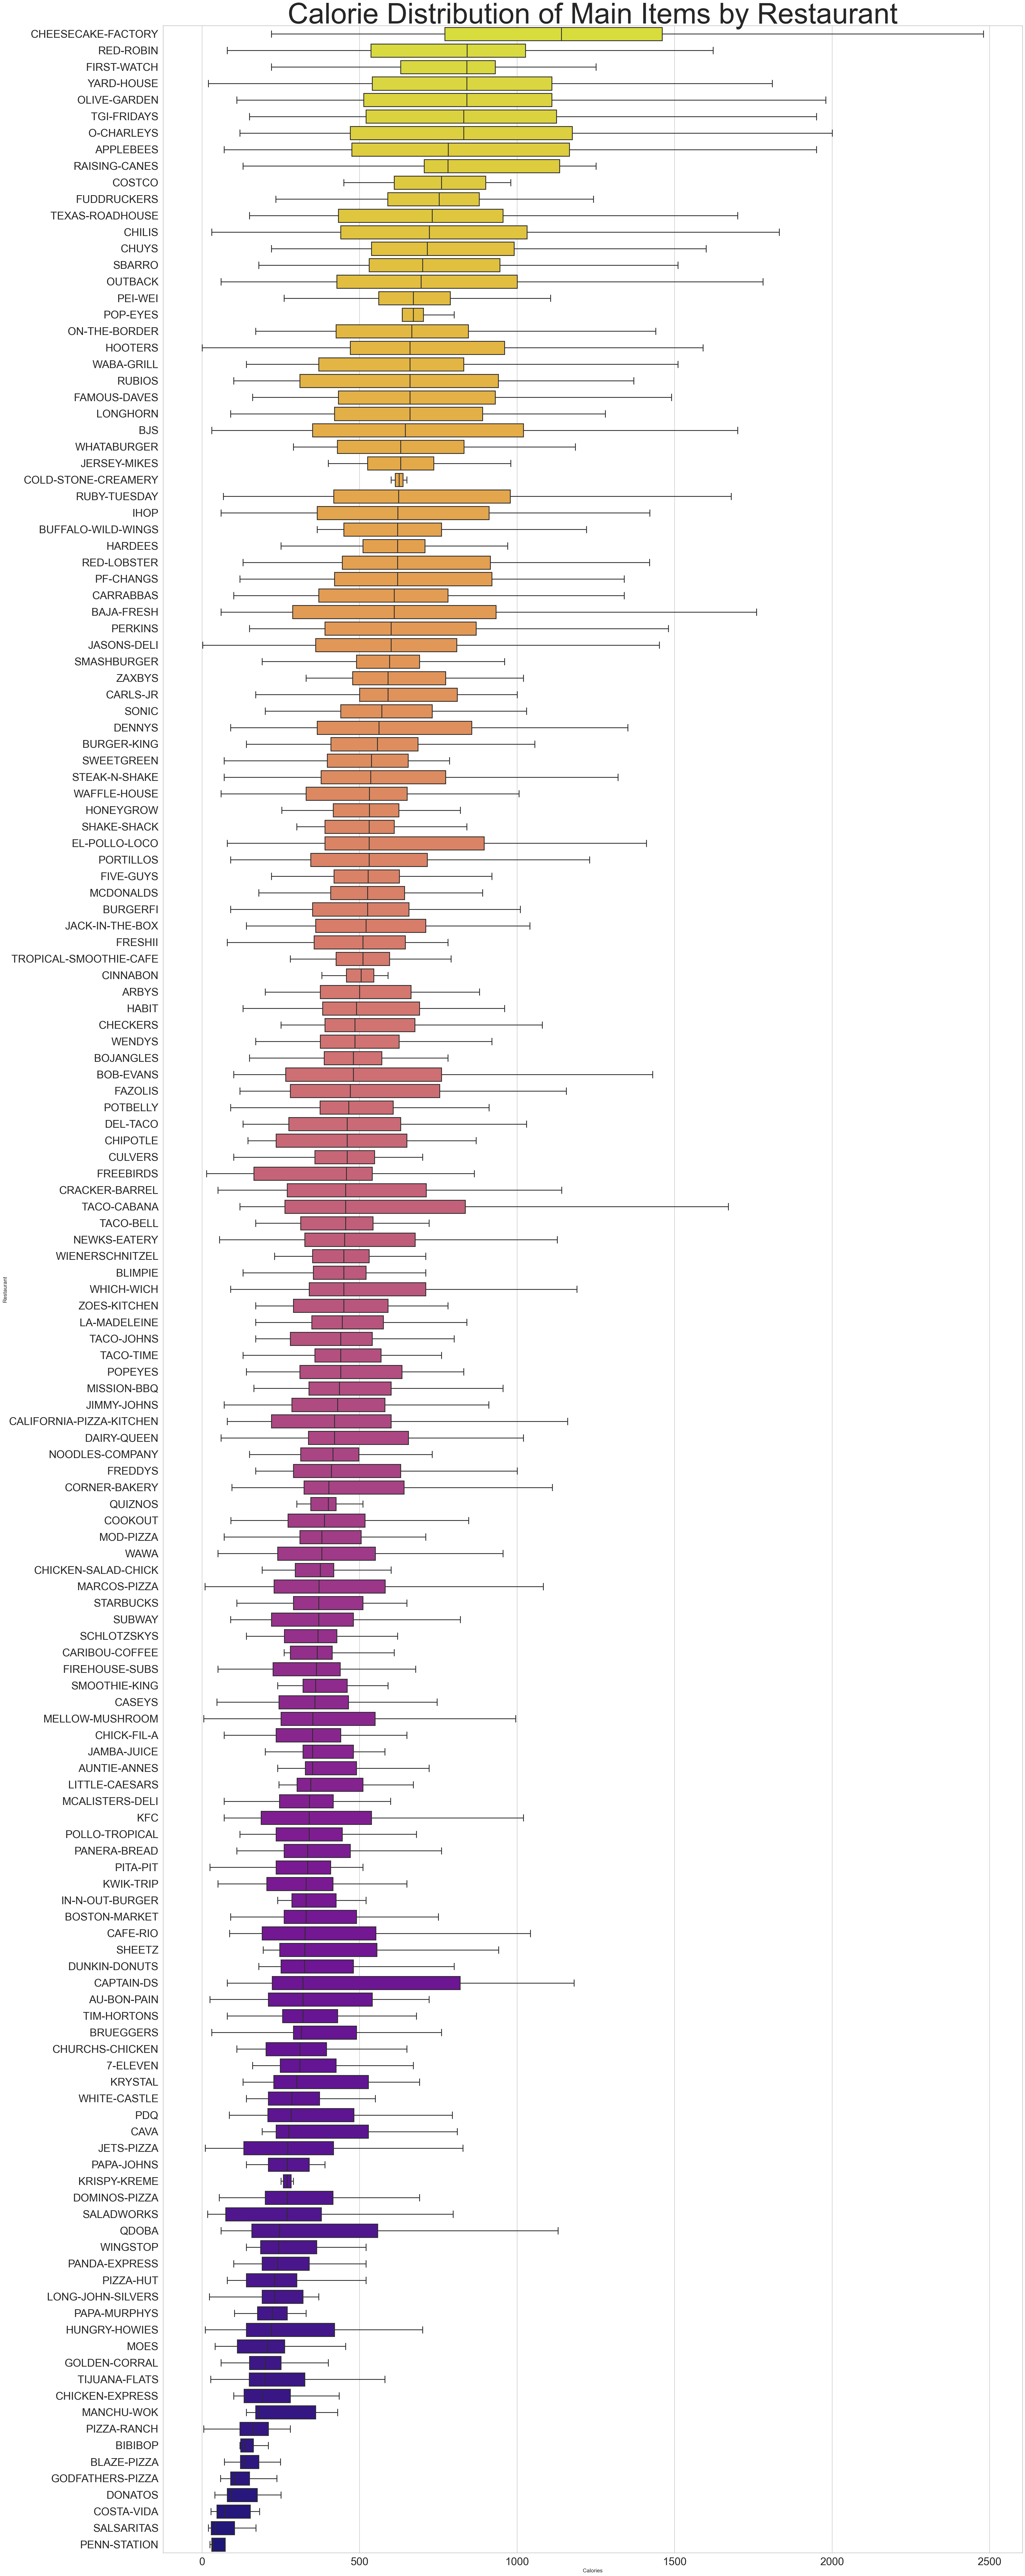

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load the dataset
df = pd.read_csv('/Users/pintoza/Desktop/dev/data-science/fast-food-nutrition/data/processed/final.csv')

# Filter the dataset for 'main' items
df_main = df[df['Classification'] == 'main']

# Define the function to remove outliers
def remove_outliers(group):
    mean = group['Calories'].mean()
    std = group['Calories'].std()
    return group[(group['Calories'] >= (mean - 3 * std)) & (group['Calories'] <= (mean + 3 * std))]

# Apply the outlier removal function and reset index
df_filtered = df_main.groupby('Restaurant').apply(remove_outliers).reset_index(drop=True)

# Calculate median values for each restaurant and sort
median_calories = df_filtered.groupby('Restaurant')['Calories'].median().sort_values(ascending=False)
sorted_restaurants = median_calories.index.tolist()

# Set the aesthetic style of the plots
sns.set_style('whitegrid')
sns.set_context('talk')

# Create the plot
plt.figure(figsize=(40, 100))
box_plot = sns.boxplot(
    x='Calories',
    y='Restaurant',
    data=df_filtered[df_filtered['Restaurant'].isin(sorted_restaurants)],
    order=sorted_restaurants,
    palette='plasma_r',  # Use a warm to cool color palette
    showfliers=False  # This removes the outlier points
)

# Enhance the plot with additional styling
box_plot.set_title('Calorie Distribution of Main Items by Restaurant', fontsize=80)
box_plot.set_xlabel('Calories', fontsize=15)
box_plot.set_ylabel('Restaurant', fontsize=15)
box_plot.tick_params(axis='both', which='major', labelsize=30)

# Display the plot
plt.tight_layout()
plt.show()